<a href="https://colab.research.google.com/github/DivyanshiChawla/Home.LLC_Test/blob/main/US_House_Price_Pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# importing the libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# loading the data
home_prices = pd.read_csv('/content/CSUSHPISA.csv', parse_dates=['DATE'], index_col='DATE')
mortgage_rate = pd.read_csv('/content/MORTGAGE30US.csv', parse_dates=['DATE'], index_col='DATE')
unemployment_rate = pd.read_csv('/content/UNRATE.csv', parse_dates=['DATE'], index_col='DATE')
income = pd.read_csv('/content/MEHOINUSA646N.csv', parse_dates=['DATE'], index_col='DATE')
cpi = pd.read_csv('/content/CPIAUCSL.csv', parse_dates=['DATE'], index_col='DATE')
gdp = pd.read_csv('/content/GDPC1.csv', parse_dates=['DATE'], index_col='DATE')

In [12]:
# for past 20 years
start_date = '2003-01-01'
end_date = '2023-12-31'

# filter dataframe to the specified date range
filtered_dfs = []
for name, df in [('home_prices', home_prices), ('mortgage_rate', mortgage_rate),
                 ('unemployment_rate', unemployment_rate), ('income', income),
                 ('cpi', cpi), ('gdp', gdp)]:
    filtered_df = df[start_date:end_date]
    filtered_dfs.append(filtered_df)
    print(f"{name}: {filtered_df.shape} - {filtered_df.index.min()} to {filtered_df.index.max()}")

home_prices: (252, 1) - 2003-01-01 00:00:00 to 2023-12-01 00:00:00
mortgage_rate: (1096, 1) - 2003-01-03 00:00:00 to 2023-12-28 00:00:00
unemployment_rate: (252, 1) - 2003-01-01 00:00:00 to 2023-12-01 00:00:00
income: (20, 1) - 2003-01-01 00:00:00 to 2022-01-01 00:00:00
cpi: (252, 1) - 2003-01-01 00:00:00 to 2023-12-01 00:00:00
gdp: (84, 1) - 2003-01-01 00:00:00 to 2023-10-01 00:00:00


In [13]:
# combining into a single DataFrame
data = pd.concat(filtered_dfs, axis=1, join='outer')
data.columns = ['HomePrices', 'MortgageRate', 'UnemploymentRate', 'Income', 'CPI', 'GDP']

In [14]:
# feature engineering
data['RealMortgageRate'] = data['MortgageRate'] - data['CPI'].pct_change(12) * 100
data['GDPperCapita'] = data['GDP'] / data['Income']
data['AffordabilityIndex'] = data['Income'] / data['HomePrices']

In [15]:
# handling missing values
print(f"Missing values before imputation:\n{data.isna().sum()}")
imputer = SimpleImputer(strategy='mean')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns, index=data.index)
print(f"Missing values after imputation:\n{data_imputed.isna().sum()}")

Missing values before imputation:
HomePrices            1063
MortgageRate           219
UnemploymentRate      1063
Income                1295
CPI                   1063
GDP                   1231
RealMortgageRate       228
GDPperCapita          1295
AffordabilityIndex    1295
dtype: int64
Missing values after imputation:
HomePrices            0
MortgageRate          0
UnemploymentRate      0
Income                0
CPI                   0
GDP                   0
RealMortgageRate      0
GDPperCapita          0
AffordabilityIndex    0
dtype: int64


In [16]:
# preparing features and target
X = data_imputed[['MortgageRate', 'UnemploymentRate', 'Income', 'CPI', 'GDP',
                  'RealMortgageRate', 'GDPperCapita', 'AffordabilityIndex']]
y = data_imputed['HomePrices']

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
lr_mae = mean_absolute_error(y_test, lr_pred)
lr_r2 = r2_score(y_test, lr_pred)
print(f"Linear Regression - MAE: {lr_mae:.2f}, R-squared: {lr_r2:.2f}")

# cross-validation for LR
lr_cv_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
lr_cv_mae = -lr_cv_scores.mean()
print(f"Linear Regression - CV MAE: {lr_cv_mae:.2f}")

Linear Regression - MAE: 4.18, R-squared: 0.83
Linear Regression - CV MAE: 3.64


In [23]:
# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.2, gamma=0, subsample=0.75,
                             colsample_bytree=1, max_depth=3, random_state=42)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)
print(f"XGBoost - MAE: {xgb_mae:.2f}, R-squared: {xgb_r2:.2f}")

# cross-validation for XGBoost
xgb_cv_scores = cross_val_score(xgb_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
xgb_cv_mae = -xgb_cv_scores.mean()
print(f"XGBoost - CV MAE: {xgb_cv_mae:.2f}")

XGBoost - MAE: 0.50, R-squared: 0.99
XGBoost - CV MAE: 0.54


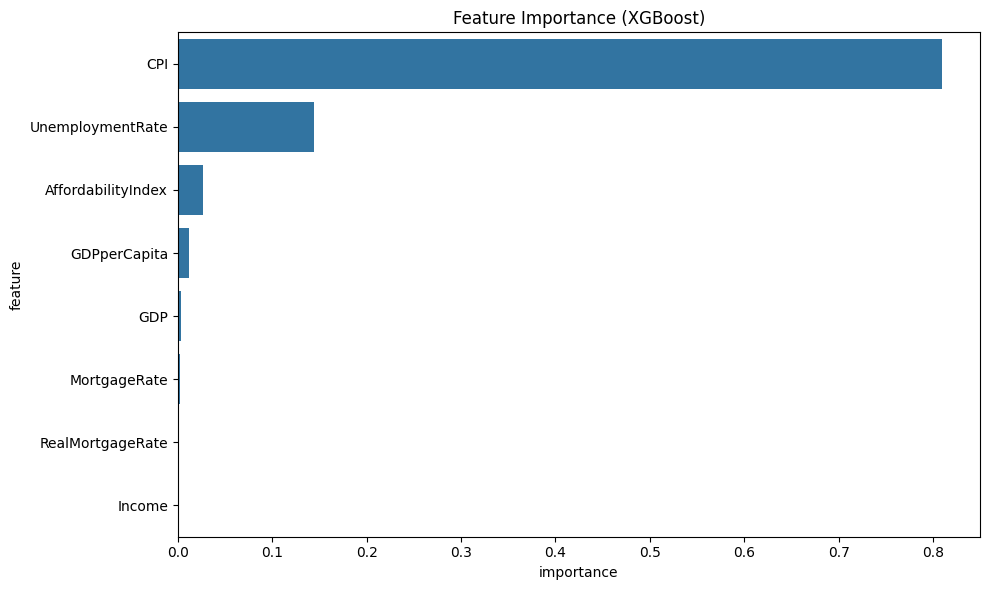

In [21]:
# feature importance from XGBoost
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': xgb_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance (XGBoost)')
plt.tight_layout()
plt.show()

In [24]:
# time series cross-validation
from sklearn.ensemble import RandomForestRegressor

# initializing the Random Forest model
tscv = TimeSeriesSplit(n_splits=5)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# cross-validation for Random Forest
all_rf_pred = []
rf_mae_scores = []
rf_r2_scores = []
for train_index, test_index in tscv.split(X_scaled):
    X_train_cv, X_test_cv = X_scaled[train_index], X_scaled[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
    rf_model.fit(X_train_cv, y_train_cv)
    rf_pred = rf_model.predict(X_test_cv)
    all_rf_pred.append(rf_pred)
    rf_mae_scores.append(mean_absolute_error(y_test_cv, rf_pred))
    rf_r2_scores.append(r2_score(y_test_cv, rf_pred))

print(f"Random Forest - MAE: {np.mean(rf_mae_scores):.2f}, R-squared: {np.mean(rf_r2_scores):.2f}")

# concatenating predictions from all folds
rf_pred_all = np.concatenate(all_rf_pred)
# length of y_test should match the concatenated predictions
y_test_all = y.iloc[np.concatenate([test_index for _, test_index in tscv.split(X_scaled)])]

Random Forest - MAE: 4.96, R-squared: 0.19


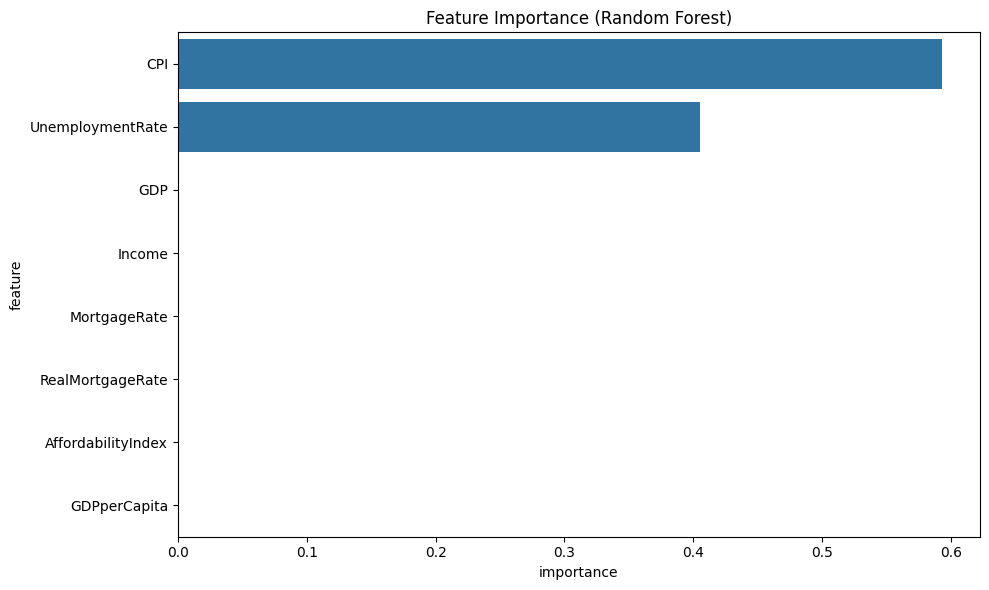

In [25]:
# feature importance from Random Forest
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()

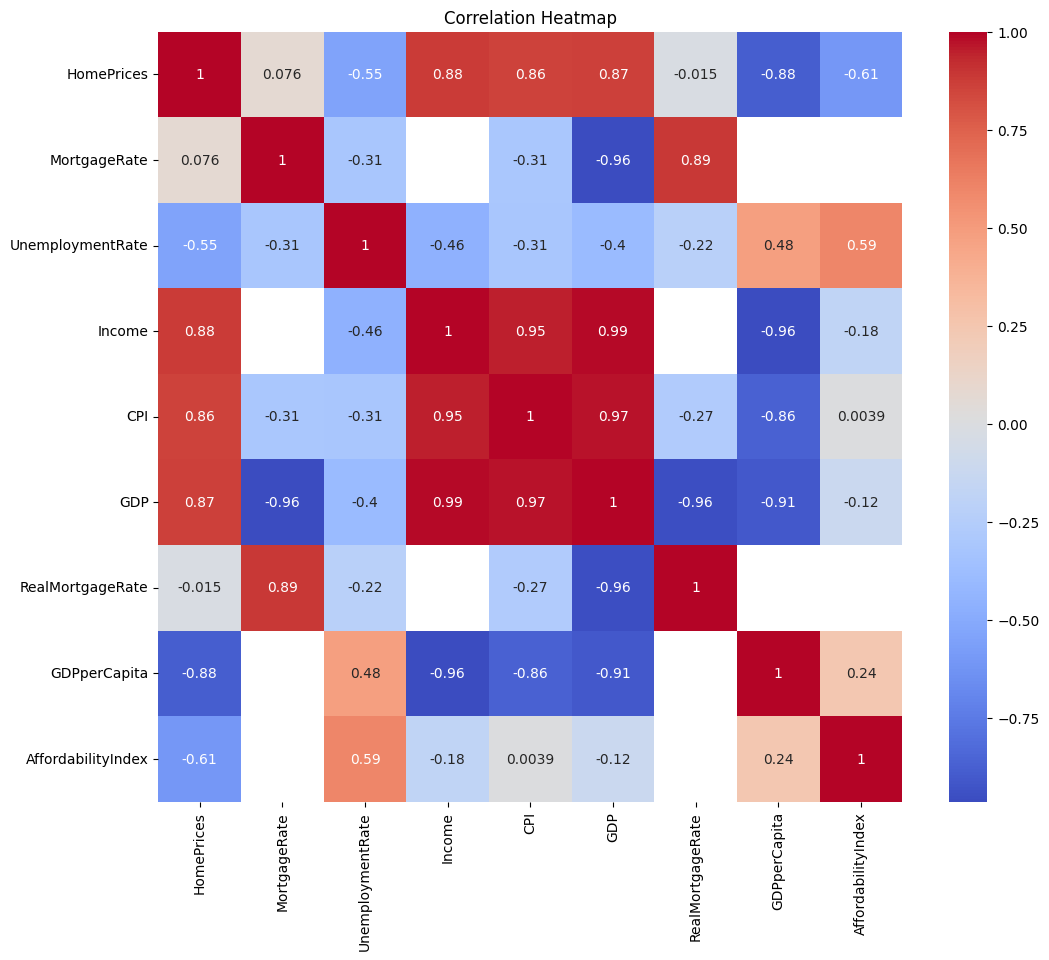

In [26]:
# correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

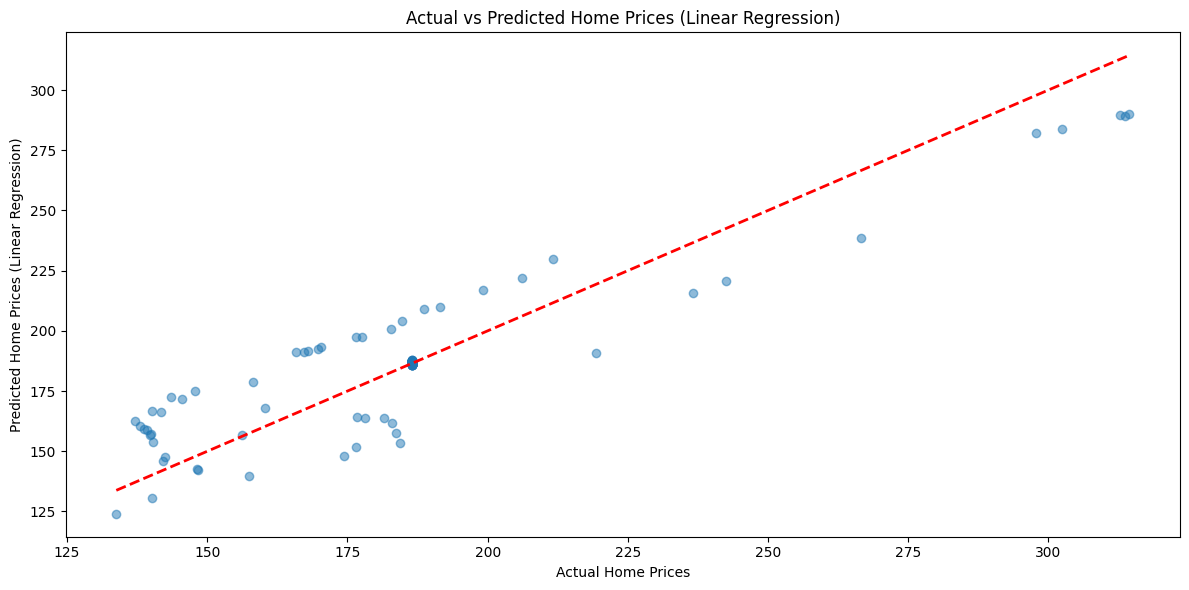

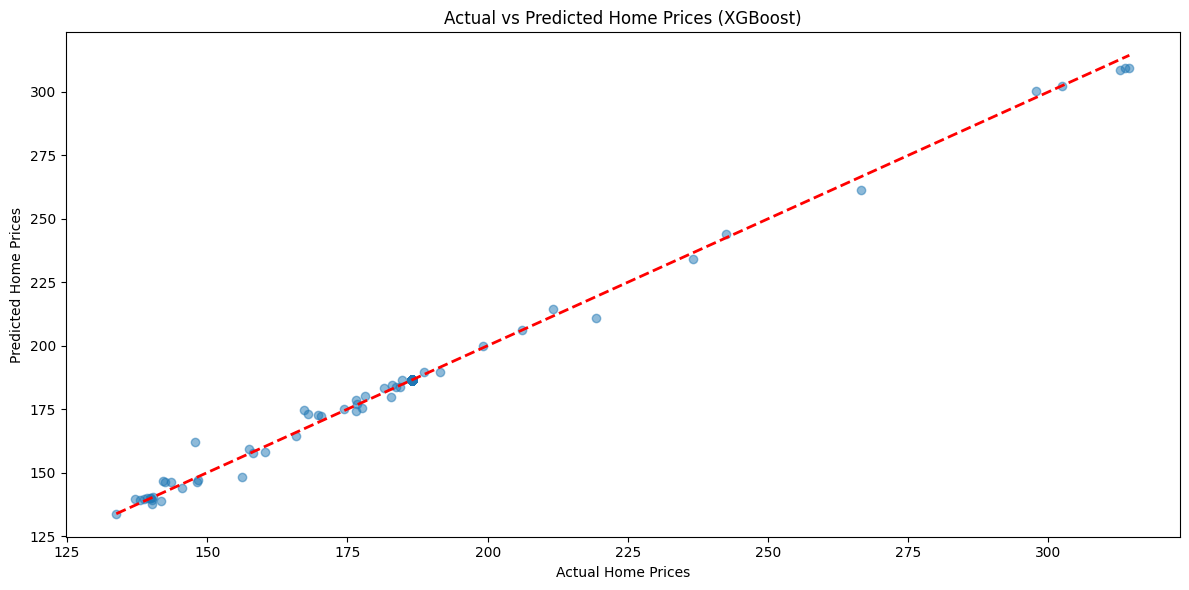

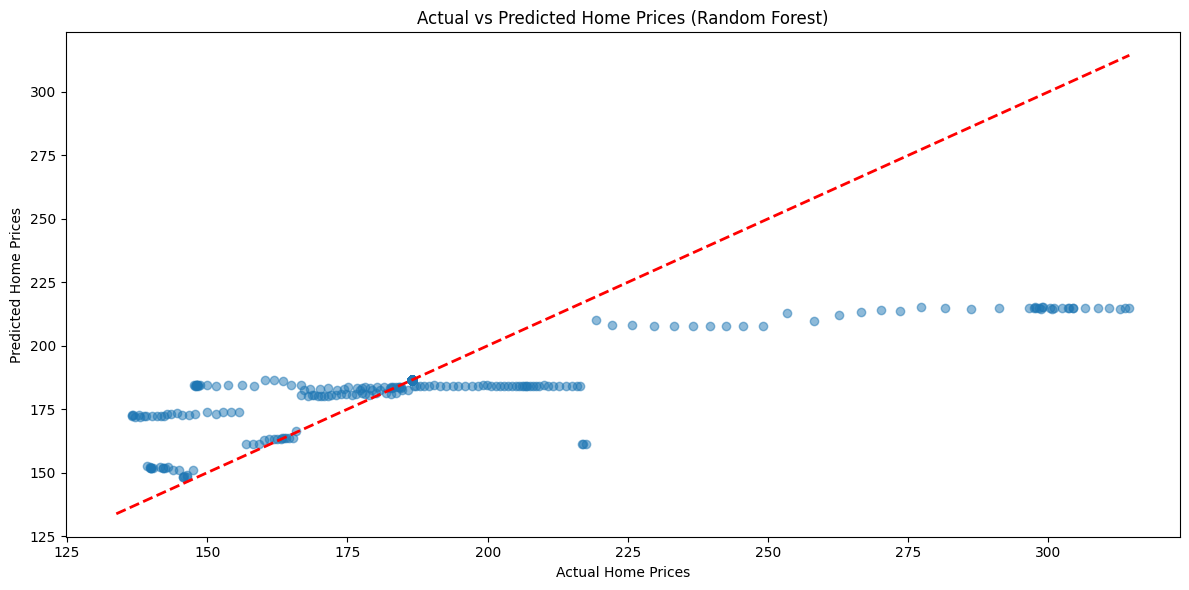

In [27]:
# actual vs predicted plot for LR
plt.figure(figsize=(12, 6))
plt.scatter(y_test, lr_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Home Prices')
plt.ylabel('Predicted Home Prices (Linear Regression)')
plt.title('Actual vs Predicted Home Prices (Linear Regression)')
plt.tight_layout()
plt.show()

# actual vs predicted plot for XGBoost
plt.figure(figsize=(12, 6))
plt.scatter(y_test, xgb_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Home Prices')
plt.ylabel('Predicted Home Prices')
plt.title('Actual vs Predicted Home Prices (XGBoost)')
plt.tight_layout()
plt.show()

# actual vs predicted plot for Random Forest
plt.figure(figsize=(12, 6))
plt.scatter(y_test_all, rf_pred_all, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Home Prices')
plt.ylabel('Predicted Home Prices')
plt.title('Actual vs Predicted Home Prices (Random Forest)')
plt.tight_layout()
plt.show()

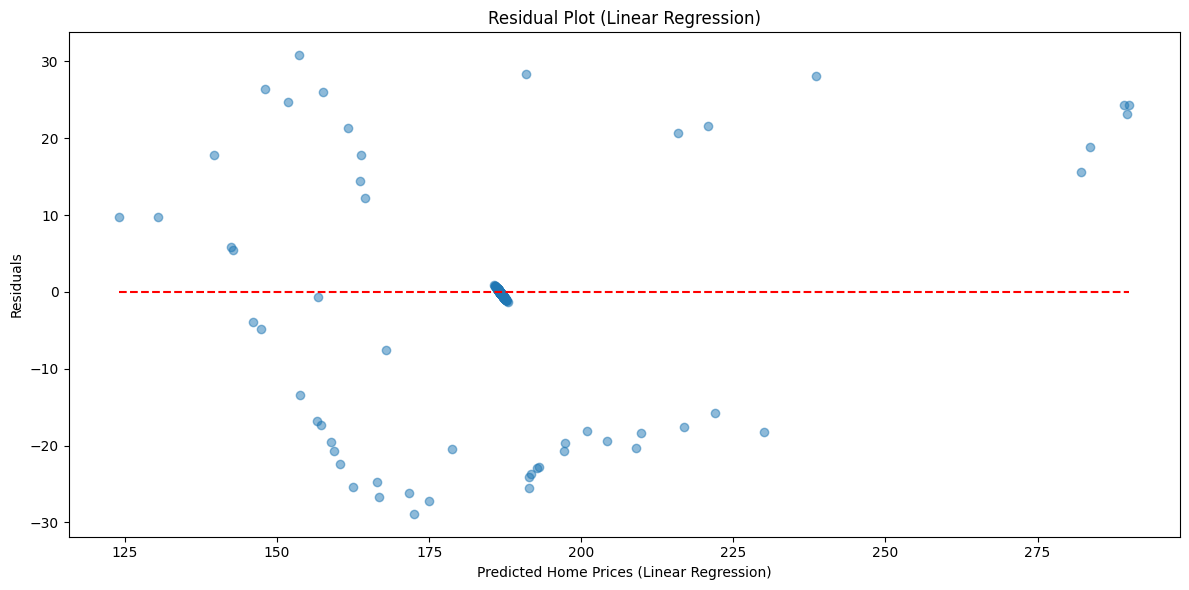

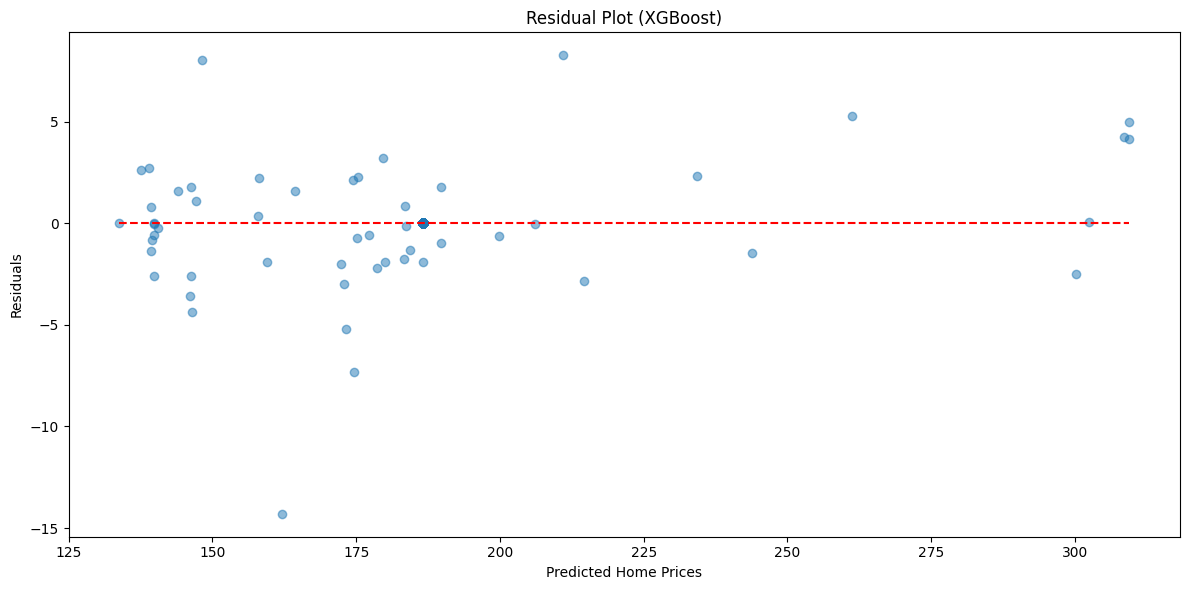

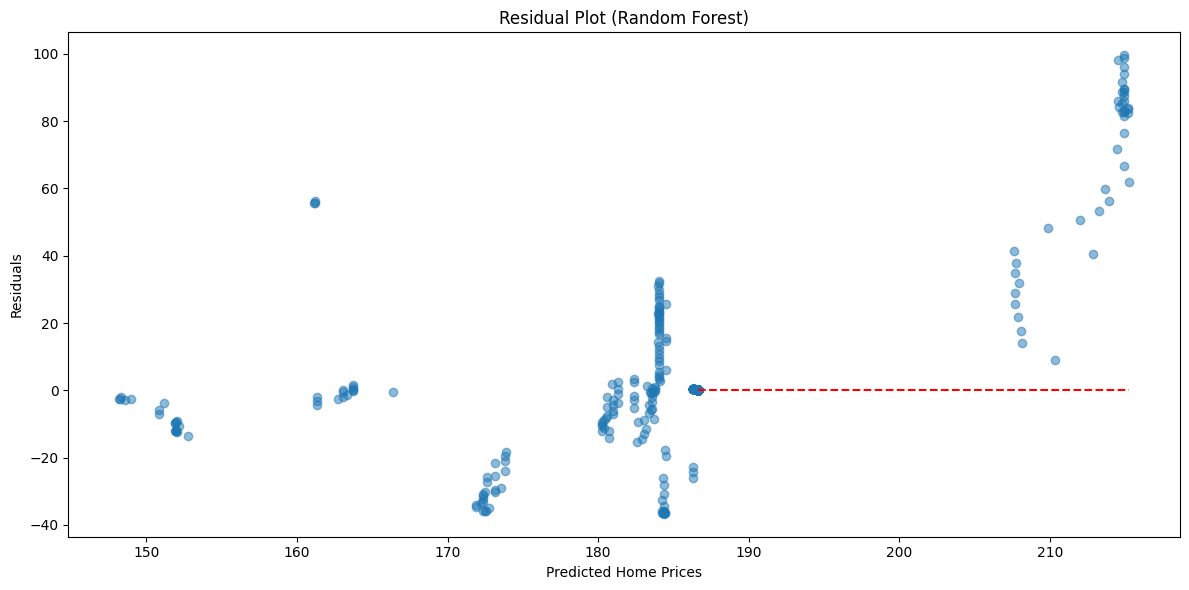

In [33]:
# residual plot for LR
lr_residuals = y_test - lr_pred
plt.figure(figsize=(12, 6))
plt.scatter(lr_pred, lr_residuals, alpha=0.5)
plt.hlines(y=0, xmin=lr_pred.min(), xmax=lr_pred.max(), colors='r', linestyles='--')
plt.xlabel('Predicted Home Prices (Linear Regression)')
plt.ylabel('Residuals')
plt.title('Residual Plot (Linear Regression)')
plt.tight_layout()
plt.show()

# residual plot for XGBoost
residuals = y_test - xgb_pred
plt.figure(figsize=(12, 6))
plt.scatter(xgb_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=xgb_pred.min(), xmax=xgb_pred.max(), colors='r', linestyles='--')
plt.xlabel('Predicted Home Prices')
plt.ylabel('Residuals')
plt.title('Residual Plot (XGBoost)')
plt.tight_layout()
plt.show()

# residual plot for Random Forest
residuals = y_test_all - rf_pred_all
plt.figure(figsize=(12, 6))
plt.scatter(rf_pred_all, residuals, alpha=0.5)
plt.hlines(y=0, xmin=rf_pred.min(), xmax=rf_pred.max(), colors='r', linestyles='--')
plt.xlabel('Predicted Home Prices')
plt.ylabel('Residuals')
plt.title('Residual Plot (Random Forest)')
plt.tight_layout()
plt.show()

In [99]:
# Print final dataset info
print(data.describe())

       HomePrices  MortgageRate  UnemploymentRate        Income         CPI  \
count  252.000000   1096.000000        252.000000     20.000000  252.000000   
mean   186.600369      4.784845          5.896825  55602.000000  233.579143   
std     48.296174      1.180105          2.051816   9250.739145   31.194197   
min    128.461000      2.650000          3.400000  43320.000000  182.600000   
25%    148.375250      3.850000          4.400000  49655.000000  212.414750   
50%    174.614500      4.540000          5.350000  52305.000000  232.918500   
75%    204.504500      5.872500          7.200000  61650.000000  252.276750   
max    314.443000      7.790000         14.800000  74580.000000  308.742000   

                GDP  RealMortgageRate  GDPperCapita  AffordabilityIndex  
count     84.000000       1087.000000     20.000000           20.000000  
mean   18299.052631          4.318596      0.325522          318.500709  
std     2166.104646          1.291108      0.016384           31.4

# XGBoost is more suitable for this problem due to its superior performance metrics and ability to handle complex relationships.
